# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [16]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [17]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [18]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [19]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [20]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [21]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [22]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [23]:
def oversampling(data):
    um_train = data[1][0]
    um_validation = data[1][1]
#     print (um_train, um_validation, data[1][2])
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
#     for i, grupo in enumerate(grupos):
#         for j, g in enumerate(grupos[i]):
#             grupos[i][j] = grupos[i][j].iloc[:,:].values
#             if len(grupos[i][j]) < tam_grupo:
#                 grupos[i][j] = np.concatenate((grupos[i][j],grupos[i][j]), axis=0)
#             grupos[i][j] = grupos[i][j][:tam_grupo]
    
    return [data[0],(um_train, um_validation, data[1][2])]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [24]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [25]:
# data_set_oversampling = oversampling(separar_grupos_tvt(separar_classes(data_set)))
# print (data_set_oversampling)
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
over = oversampling(grupos)
print (len(over[0][0]), len(over[0][1]), len(over[0][2]), 
       len(over[1][0]), len(over[1][1]), len(over[1][2]))

join_c = join_class(over)
print (len(join_c[0]), len(join_c[1]), len(join_c[2]))

7592 253
5694 949 949 189 32 32
5694 949 949 5694 949 32
11388 1898 981


### Separando entrada de saida

In [26]:
# columns = data_set.columns.tolist()
# shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
# rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
X_train = join_c[0][:,:-1]
y_train = join_c[0][:,-1]

X_validation = join_c[1][:,:-1]
y_validation = join_c[1][:,-1]

X_test = join_c[2][:,:-1]
y_test = join_c[2][:,-1]
# print (y_validation)


# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 5694, 1.0: 5694})
Counter({0.0: 949, 1.0: 949})
Counter({0.0: 949, 1.0: 32})


### Normalização dos dados

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [31]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=1000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 11388 samples, validate on 1898 samples
Epoch 1/1000
11388/11388 [==============================] - 0s - loss: 0.3007 - acc: 0.6259 - val_loss: 0.1197 - val_acc: 0.8172
Epoch 2/1000
11388/11388 [==============================] - 0s - loss: 0.1356 - acc: 0.8176 - val_loss: 0.0808 - val_acc: 0.8741
Epoch 3/1000
11388/11388 [==============================] - 0s - loss: 0.1144 - acc: 0.8580 - val_loss: 0.0824 - val_acc: 0.8620
Epoch 4/1000
11388/11388 [==============================] - 0s - loss: 0.1031 - acc: 0.8837 - val_loss: 0.0814 - val_acc: 0.8778
Epoch 5/1000
11388/11388 [==============================] - 0s - loss: 0.0968 - acc: 0.8921 - val_loss: 0.0767 - val_acc: 0.8920
Epoch 6/1000
11388/11388 [==============================] - 0s - loss: 0.0938 - acc: 0.8934 - val_loss: 0.0741 - val_acc: 0.8909
Epoch 7/1000
11388/11388 [==============================] - 0s - loss: 0.0924 - acc: 0.8965 - val_loss: 0.0717 - val_acc: 0.8909
Epoch 8/1000
11388/11388 [======================

11388/11388 [==============================] - 0s - loss: 0.0840 - acc: 0.9035 - val_loss: 0.0636 - val_acc: 0.8883
Epoch 64/1000
11388/11388 [==============================] - 0s - loss: 0.0840 - acc: 0.9033 - val_loss: 0.0656 - val_acc: 0.8878
Epoch 65/1000
11388/11388 [==============================] - 0s - loss: 0.0840 - acc: 0.9031 - val_loss: 0.0655 - val_acc: 0.8883
Epoch 66/1000
11388/11388 [==============================] - 0s - loss: 0.0840 - acc: 0.9037 - val_loss: 0.0646 - val_acc: 0.8872
Epoch 67/1000
11388/11388 [==============================] - 0s - loss: 0.0839 - acc: 0.9031 - val_loss: 0.0661 - val_acc: 0.8894
Epoch 68/1000
11388/11388 [==============================] - 0s - loss: 0.0838 - acc: 0.9038 - val_loss: 0.0666 - val_acc: 0.8883
Epoch 69/1000
11388/11388 [==============================] - 0s - loss: 0.0839 - acc: 0.9026 - val_loss: 0.0653 - val_acc: 0.8878
Epoch 70/1000
11388/11388 [==============================] - 0s - loss: 0.0837 - acc: 0.9038 - val_loss:

11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9064 - val_loss: 0.0749 - val_acc: 0.8699
Epoch 126/1000
11388/11388 [==============================] - 0s - loss: 0.0823 - acc: 0.9067 - val_loss: 0.0784 - val_acc: 0.8699
Epoch 127/1000
11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9067 - val_loss: 0.0753 - val_acc: 0.8688
Epoch 128/1000
11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9065 - val_loss: 0.0772 - val_acc: 0.8693
Epoch 129/1000
11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9069 - val_loss: 0.0761 - val_acc: 0.8693
Epoch 130/1000
11388/11388 [==============================] - 0s - loss: 0.0823 - acc: 0.9060 - val_loss: 0.0779 - val_acc: 0.8699
Epoch 131/1000
11388/11388 [==============================] - 0s - loss: 0.0820 - acc: 0.9066 - val_loss: 0.0801 - val_acc: 0.8699
Epoch 132/1000
11388/11388 [==============================] - 0s - loss: 0.0821 - acc: 0.9066 - va

11388/11388 [==============================] - 0s - loss: 0.0816 - acc: 0.9065 - val_loss: 0.0906 - val_acc: 0.8704
Epoch 188/1000
11388/11388 [==============================] - 0s - loss: 0.0815 - acc: 0.9066 - val_loss: 0.0889 - val_acc: 0.8704
Epoch 189/1000
11388/11388 [==============================] - 0s - loss: 0.0816 - acc: 0.9069 - val_loss: 0.0871 - val_acc: 0.8704
Epoch 190/1000
11388/11388 [==============================] - 0s - loss: 0.0816 - acc: 0.9067 - val_loss: 0.0902 - val_acc: 0.8704
Epoch 191/1000
11388/11388 [==============================] - 0s - loss: 0.0816 - acc: 0.9066 - val_loss: 0.0861 - val_acc: 0.8699
Epoch 192/1000
11388/11388 [==============================] - 0s - loss: 0.0816 - acc: 0.9066 - val_loss: 0.0894 - val_acc: 0.8699
Epoch 193/1000
11388/11388 [==============================] - 0s - loss: 0.0815 - acc: 0.9067 - val_loss: 0.0911 - val_acc: 0.8709
Epoch 194/1000
11388/11388 [==============================] - 0s - loss: 0.0816 - acc: 0.9066 - va

11388/11388 [==============================] - 0s - loss: 0.0823 - acc: 0.9075 - val_loss: 0.0836 - val_acc: 0.8699
Epoch 250/1000
11388/11388 [==============================] - 0s - loss: 0.0824 - acc: 0.9075 - val_loss: 0.0929 - val_acc: 0.8736
Epoch 251/1000
11388/11388 [==============================] - 0s - loss: 0.0824 - acc: 0.9075 - val_loss: 0.0936 - val_acc: 0.8725
Epoch 252/1000
11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9079 - val_loss: 0.0890 - val_acc: 0.8725
Epoch 253/1000
11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9081 - val_loss: 0.0908 - val_acc: 0.8714
Epoch 254/1000
11388/11388 [==============================] - 0s - loss: 0.0822 - acc: 0.9080 - val_loss: 0.0930 - val_acc: 0.8709
Epoch 255/1000
11388/11388 [==============================] - 0s - loss: 0.0823 - acc: 0.9079 - val_loss: 0.0911 - val_acc: 0.8878
Epoch 256/1000
11388/11388 [==============================] - 0s - loss: 0.0823 - acc: 0.9078 - va

11388/11388 [==============================] - 0s - loss: 0.0812 - acc: 0.9096 - val_loss: 0.0957 - val_acc: 0.8888
Epoch 312/1000
11388/11388 [==============================] - 0s - loss: 0.0813 - acc: 0.9093 - val_loss: 0.1033 - val_acc: 0.8741
Epoch 313/1000
11388/11388 [==============================] - 0s - loss: 0.0814 - acc: 0.9091 - val_loss: 0.0988 - val_acc: 0.8904
Epoch 314/1000
11388/11388 [==============================] - 0s - loss: 0.0812 - acc: 0.9094 - val_loss: 0.0961 - val_acc: 0.8736
Epoch 315/1000
11388/11388 [==============================] - 0s - loss: 0.0811 - acc: 0.9096 - val_loss: 0.1026 - val_acc: 0.8899
Epoch 316/1000
11388/11388 [==============================] - 0s - loss: 0.0813 - acc: 0.9095 - val_loss: 0.0975 - val_acc: 0.8741
Epoch 317/1000
11388/11388 [==============================] - 0s - loss: 0.0812 - acc: 0.9094 - val_loss: 0.0894 - val_acc: 0.8888
Epoch 318/1000
11388/11388 [==============================] - 0s - loss: 0.0812 - acc: 0.9096 - va

11388/11388 [==============================] - 0s - loss: 0.0815 - acc: 0.9105 - val_loss: 0.0999 - val_acc: 0.8930
Epoch 374/1000
11388/11388 [==============================] - 0s - loss: 0.0810 - acc: 0.9116 - val_loss: 0.0993 - val_acc: 0.8946
Epoch 375/1000
11388/11388 [==============================] - 0s - loss: 0.0804 - acc: 0.9124 - val_loss: 0.0974 - val_acc: 0.8967
Epoch 376/1000
11388/11388 [==============================] - 0s - loss: 0.0798 - acc: 0.9134 - val_loss: 0.0973 - val_acc: 0.8978
Epoch 377/1000
11388/11388 [==============================] - 0s - loss: 0.0796 - acc: 0.9138 - val_loss: 0.0978 - val_acc: 0.8967
Epoch 378/1000
11388/11388 [==============================] - 0s - loss: 0.0795 - acc: 0.9140 - val_loss: 0.0971 - val_acc: 0.8978
Epoch 379/1000
11388/11388 [==============================] - 0s - loss: 0.0791 - acc: 0.9142 - val_loss: 0.0975 - val_acc: 0.8973
Epoch 380/1000
11388/11388 [==============================] - 0s - loss: 0.0789 - acc: 0.9146 - va

11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9160 - val_loss: 0.1102 - val_acc: 0.8836
Epoch 436/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9155 - val_loss: 0.1103 - val_acc: 0.8836
Epoch 437/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9161 - val_loss: 0.1103 - val_acc: 0.8841
Epoch 438/1000
11388/11388 [==============================] - 0s - loss: 0.0779 - acc: 0.9162 - val_loss: 0.1094 - val_acc: 0.8851
Epoch 439/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9157 - val_loss: 0.1115 - val_acc: 0.8841
Epoch 440/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9161 - val_loss: 0.1101 - val_acc: 0.8841
Epoch 441/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9161 - val_loss: 0.1106 - val_acc: 0.8846
Epoch 442/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9156 - va

11388/11388 [==============================] - 0s - loss: 0.0779 - acc: 0.9164 - val_loss: 0.1110 - val_acc: 0.8836
Epoch 498/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9157 - val_loss: 0.1118 - val_acc: 0.8841
Epoch 499/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9163 - val_loss: 0.1096 - val_acc: 0.8851
Epoch 500/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9160 - val_loss: 0.1104 - val_acc: 0.8841
Epoch 501/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9160 - val_loss: 0.1149 - val_acc: 0.8836
Epoch 502/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9161 - val_loss: 0.1124 - val_acc: 0.8836
Epoch 503/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9157 - val_loss: 0.1107 - val_acc: 0.8836
Epoch 504/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9160 - va

11388/11388 [==============================] - 0s - loss: 0.0779 - acc: 0.9162 - val_loss: 0.1111 - val_acc: 0.8841
Epoch 560/1000
11388/11388 [==============================] - 0s - loss: 0.0779 - acc: 0.9162 - val_loss: 0.1116 - val_acc: 0.8830
Epoch 561/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9161 - val_loss: 0.1153 - val_acc: 0.8672
Epoch 562/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9159 - val_loss: 0.1117 - val_acc: 0.8836
Epoch 563/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9160 - val_loss: 0.1189 - val_acc: 0.8678
Epoch 564/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9161 - val_loss: 0.1111 - val_acc: 0.8830
Epoch 565/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9157 - val_loss: 0.1110 - val_acc: 0.8830
Epoch 566/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9161 - va

11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9169 - val_loss: 0.1035 - val_acc: 0.8867
Epoch 622/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9171 - val_loss: 0.1081 - val_acc: 0.8867
Epoch 623/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9171 - val_loss: 0.1060 - val_acc: 0.8894
Epoch 624/1000
11388/11388 [==============================] - 0s - loss: 0.0785 - acc: 0.9165 - val_loss: 0.1020 - val_acc: 0.8888
Epoch 625/1000
11388/11388 [==============================] - 0s - loss: 0.0784 - acc: 0.9164 - val_loss: 0.1051 - val_acc: 0.8883
Epoch 626/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9172 - val_loss: 0.1060 - val_acc: 0.8883
Epoch 627/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9169 - val_loss: 0.1080 - val_acc: 0.8872
Epoch 628/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9169 - va

11388/11388 [==============================] - 0s - loss: 0.0784 - acc: 0.9165 - val_loss: 0.0978 - val_acc: 0.8883
Epoch 684/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9166 - val_loss: 0.1048 - val_acc: 0.8867
Epoch 685/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9170 - val_loss: 0.1015 - val_acc: 0.8883
Epoch 686/1000
11388/11388 [==============================] - 0s - loss: 0.0784 - acc: 0.9168 - val_loss: 0.1040 - val_acc: 0.8872
Epoch 687/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9171 - val_loss: 0.1006 - val_acc: 0.8888
Epoch 688/1000
11388/11388 [==============================] - 0s - loss: 0.0787 - acc: 0.9161 - val_loss: 0.0943 - val_acc: 0.9031
Epoch 689/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9171 - val_loss: 0.0964 - val_acc: 0.8883
Epoch 690/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9169 - va

11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9167 - val_loss: 0.1070 - val_acc: 0.8894
Epoch 746/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9173 - val_loss: 0.1067 - val_acc: 0.8878
Epoch 747/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9168 - val_loss: 0.1071 - val_acc: 0.8888
Epoch 748/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9172 - val_loss: 0.1067 - val_acc: 0.8894
Epoch 749/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9170 - val_loss: 0.1083 - val_acc: 0.8862
Epoch 750/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9168 - val_loss: 0.1004 - val_acc: 0.8867
Epoch 751/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9172 - val_loss: 0.1069 - val_acc: 0.8867
Epoch 752/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9170 - va

11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9168 - val_loss: 0.0939 - val_acc: 0.9031
Epoch 808/1000
11388/11388 [==============================] - 0s - loss: 0.0791 - acc: 0.9161 - val_loss: 0.0923 - val_acc: 0.9020
Epoch 809/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9173 - val_loss: 0.1071 - val_acc: 0.8872
Epoch 810/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9170 - val_loss: 0.1070 - val_acc: 0.8883
Epoch 811/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9171 - val_loss: 0.1026 - val_acc: 0.8878
Epoch 812/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9171 - val_loss: 0.0935 - val_acc: 0.9036
Epoch 813/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9168 - val_loss: 0.0981 - val_acc: 0.8867
Epoch 814/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - va

11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9172 - val_loss: 0.1074 - val_acc: 0.8878
Epoch 870/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9172 - val_loss: 0.1071 - val_acc: 0.8888
Epoch 871/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9171 - val_loss: 0.1067 - val_acc: 0.8894
Epoch 872/1000
11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9175 - val_loss: 0.1067 - val_acc: 0.8894
Epoch 873/1000
11388/11388 [==============================] - 0s - loss: 0.0785 - acc: 0.9166 - val_loss: 0.1073 - val_acc: 0.8888
Epoch 874/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9170 - val_loss: 0.1028 - val_acc: 0.8872
Epoch 875/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9169 - val_loss: 0.1064 - val_acc: 0.8878
Epoch 876/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9173 - va

11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9171 - val_loss: 0.1064 - val_acc: 0.8888
Epoch 932/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9168 - val_loss: 0.0963 - val_acc: 0.9020
Epoch 933/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9170 - val_loss: 0.0986 - val_acc: 0.8883
Epoch 934/1000
11388/11388 [==============================] - 0s - loss: 0.0785 - acc: 0.9167 - val_loss: 0.0932 - val_acc: 0.9020
Epoch 935/1000
11388/11388 [==============================] - 1s - loss: 0.0781 - acc: 0.9172 - val_loss: 0.0974 - val_acc: 0.8883
Epoch 936/1000
11388/11388 [==============================] - 1s - loss: 0.0788 - acc: 0.9164 - val_loss: 0.0985 - val_acc: 0.8878
Epoch 937/1000
11388/11388 [==============================] - 1s - loss: 0.0780 - acc: 0.9172 - val_loss: 0.0977 - val_acc: 0.8867
Epoch 938/1000
11388/11388 [==============================] - 1s - loss: 0.0784 - acc: 0.9167 - va

11388/11388 [==============================] - 0s - loss: 0.0780 - acc: 0.9176 - val_loss: 0.1069 - val_acc: 0.8888
Epoch 994/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9168 - val_loss: 0.1046 - val_acc: 0.8867
Epoch 995/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9173 - val_loss: 0.1067 - val_acc: 0.8888
Epoch 996/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9170 - val_loss: 0.1067 - val_acc: 0.8888
Epoch 997/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9169 - val_loss: 0.1035 - val_acc: 0.8878
Epoch 998/1000
11388/11388 [==============================] - 0s - loss: 0.0783 - acc: 0.9166 - val_loss: 0.1073 - val_acc: 0.8872
Epoch 999/1000
11388/11388 [==============================] - 0s - loss: 0.0782 - acc: 0.9168 - val_loss: 0.0963 - val_acc: 0.8872
Epoch 1000/1000
11388/11388 [==============================] - 0s - loss: 0.0781 - acc: 0.9173 - v

In [32]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

 32/981 [..............................] - ETA: 0s[0.057953208692516148, 0.92150866474944881]


Algumas funções auxiliares.

In [35]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

# def extract_final_losses(history):
#     train_acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     idx_min_val_acc = np.argmin(val_acc)
    
#     return {'train_acc': train_acc[idx_min_val_acc], 'val_loss': val_acc[idx_min_val_acc]}


def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


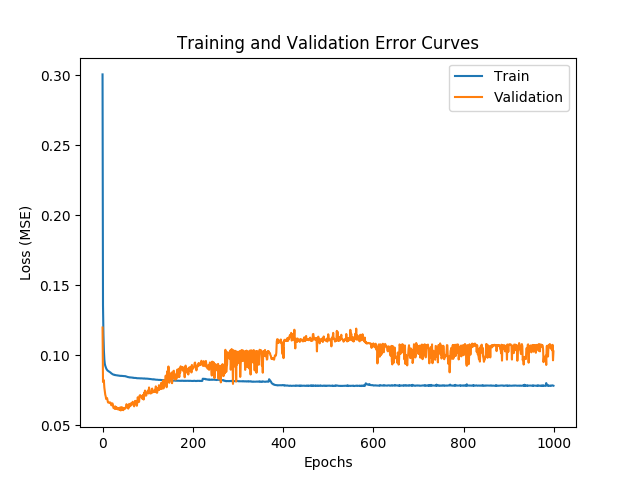

<IPython.core.display.Javascript object>


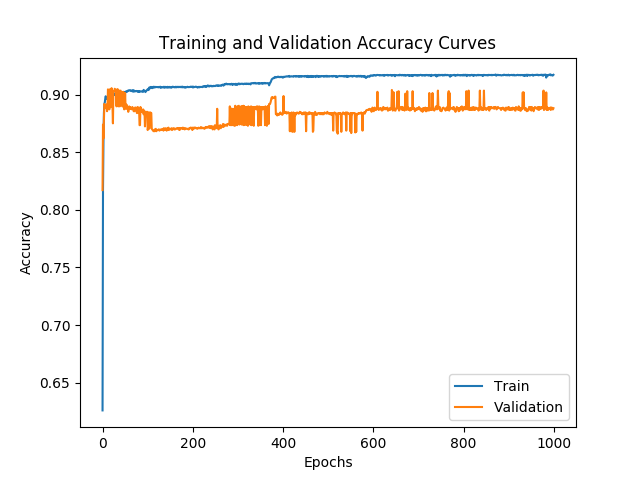

In [33]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [36]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[879  70]
 [  6  26]]

Train Loss:       0.0852
Validation Loss:  0.0604
Accuracy:         0.9225
Recall:           0.8125
Precision:        0.2708
F1:               0.4062
AUROC:            0.8926
